In [251]:
from pathlib import Path
import sys
sys.path.append("../../")

In [252]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import random

from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns

from models.vae import Base, LMCVAE
from distributions.samplers import HMC, run_chain
from distributions.distributions import Funnel
from distributions.pyro_samplers import NUTS
from torch.distributions import MultivariateNormal as MNormal, Normal
from pints.toy import NealsFunnelLogPDF

import numpy as np

import pytorch_lightning as pl
from pytorch_lightning import loggers as pl_loggers

%matplotlib widget

In [253]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [254]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [255]:
n_steps = 1
dist = "funnel"
dim = 30
scale_proposal = 1.
scale_isir = 5.
dist_class = "Funnel"
dist_params = {
    "b": 2,
    "sigma":5.0,
}
sigma = 5
b = 0.8

In [256]:
# Данные
target = Funnel(
                dim=dim,
                device=device,
                b = b,
                sigma = sigma,

)

loc_proposal = torch.zeros(dim).to(device)
scale_proposal = scale_proposal * torch.ones(dim).to(device)
scale_isir = scale_isir * torch.ones(dim).to(device)



In [257]:
class Funnel_Dataset(Dataset):
    def __init__(self, data):
        super(Funnel_Dataset, self).__init__()
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, item):
        sample = torch.tensor(self.data[item], dtype=torch.float32, device=device)
        return sample, -1.

In [258]:
latent_dim = 2*dim


class FunnelEncoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.net = nn.Sequential(
            nn.Linear(dim, 2*dim),
            nn.ReLU(),
            nn.Linear(2*dim, latent_dim),
        )

    def forward(self, x):
        return self.net(x)

    
class FunnelDecoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(latent_dim // 2, 2*dim),
            nn.ReLU(),
            nn.Linear(2*dim, dim),
        )

    def forward(self, x):
        return self.net(x)
    

class TrueDecoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.b = b
        self.sigma = sigma

    def forward(self, z):
        z[:,0] *= b 
        for i in range(1, z.size(1)):
            z[:,i] *= np.exp(z[:,0]/2) 
        return z
    


In [259]:
def generate_dataset(N_samples, dim, sigma = 1.0):
    np.random.seed(42)
    True_samples = np.random.randn(N_samples, dim)
    True_samples[:,0] *= b 
    for i in range(1, dim):
        True_samples[:,i] *= np.exp(True_samples[:,0]/2) 
    return True_samples



class Toy(Base):   
    def joint_logdensity(self, use_true_decoder=None):
        def density(z, x):
            if (use_true_decoder is not None) and use_true_decoder:
                x_reconst = self(z)
            elif hasattr(self, 'use_cloned_decoder') and self.use_cloned_decoder:
                x_reconst = self.cloned_decoder(z)
            else:
                x_reconst = self(z)

            logprob1 = Normal(0,b).log_prob(z[..., 0])
            z_new = z[..., 0]
            logprob2 = (
                -0.5 * (z[..., 1:] ** 2).sum(-1) * torch.exp(-2 * 0.5 * z_new)
                - (dim - 1) * 0.5 * z_new
            )
            return logprob1 + logprob2

        return density

    
class LMCVAE_Toy(LMCVAE, Toy):
    def loss_function(self, sum_log_weights):
        loss = super(LMCVAE_Toy, self).loss_function(sum_log_weights)
        return loss


In [260]:
N = 10000
d = dim
b = 0.7
eps = 2 + np.random.randn(1, d)
X_train = generate_dataset(N_samples=N, dim=d, sigma=sigma)
X_val = generate_dataset(N_samples=N // 100, dim=d, sigma=sigma)
train_dataset = Funnel_Dataset(data= X_train)
val_dataset = Funnel_Dataset(data=X_val)
train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True,)
val_loader = DataLoader(val_dataset, batch_size=10, shuffle=False)

In [261]:
funnel_enc = FunnelEncoder().to(device)

In [262]:
def replace_enc_dec(model):
    model.encoder_net = FunnelEncoder().to(device)
    model.decoder_net = FunnelDecoder().to(device)
    model = model.to(device)
    return model

In [263]:
seed_everything(42)
lmcvae = LMCVAE_Toy(shape=2, act_func=nn.LeakyReLU,
                    num_samples=1, hidden_dim=d,
                    net_type='conv', dataset='toy',
                    step_size=0.01, K=5, use_transforms=False, learnable_transitions=False, return_pre_alphas=True, use_score_matching=False,
                    ula_skip_threshold=0.1, grad_skip_val=0., grad_clip_val=0., use_cloned_decoder=False, variance_sensitive_step=True,
                    acceptance_rate_target=0.9, annealing_scheme='all_learnable')
lmcvae = replace_enc_dec(lmcvae)
lmcvae.name = 'LMCVAE'

In [264]:
def run_trainer(model):
    seed_everything(42)
    tb_logger = pl_loggers.TensorBoardLogger('lightning_logs/')
    trainer = pl.Trainer(logger=tb_logger, fast_dev_run=False, max_epochs=31) #automatic_optimization=True
    trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=val_loader)

In [265]:
run_trainer(lmcvae)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name            | Type          | Params
--------------------------------------------------
0 | encoder_net     | FunnelEncoder | 5.5 K 
1 | decoder_net     | FunnelDecoder | 3.7 K 
2 | transitions_nll | ModuleList    | 8     
3 | transitions     | ModuleList    | 5     
--------------------------------------------------
9.2 K     Trainable params
13        Non-trainable params
9.2 K     Total params
0.037     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=31` reached.


In [266]:
n_leapfrogs = 5
step_size = 0.1
n_samples = 6000
hmc = HMC(n_leapfrogs=n_leapfrogs, step_size=step_size, partial_ref=False, use_barker=False).to(device)


True_post_samples = np.random.randn(n_samples,dim)
True_post_samples[:,0] *= b
for i in range(1, dim):
  True_post_samples[:,i] *= np.exp(True_post_samples[:,0]/2) 


X_item = torch.tensor(True_post_samples, device=device, dtype=torch.float32)



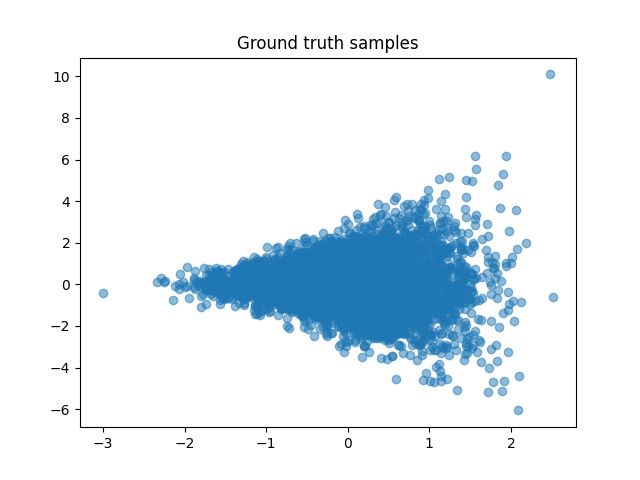

In [267]:
fig,ax=plt.subplots(1,1)
X_ = X_item.to('cpu')

ax.scatter(X_[:,0],X_[:,1], alpha=0.5)
ax.set_title('Ground truth samples')
plt.show()

In [268]:
## Receive true posterior sample:
def target_density(z, x):


    logprob1 = Normal(0,b).log_prob(z[..., 0])
    z_new = z[..., 0]
    logprob2 = (
        -0.5 * (z[..., 1:] ** 2).sum(-1) * torch.exp(-2 * 0.5 * z_new)
        - (dim - 1) * 0.5 * z_new
    )
    return logprob1 + logprob2




                
true_posterior_samples = run_chain(kernel=hmc, z_init=torch.randn(n_samples, dim, device=device), target=target_density, return_trace=False,
                                   n_steps=1, burnin=500).cpu()

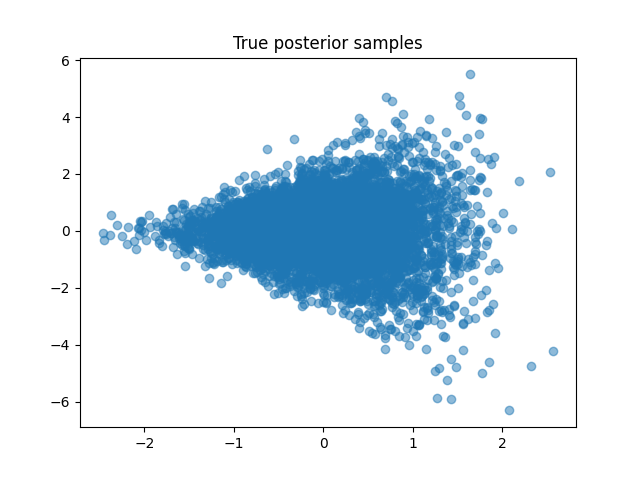

In [269]:
fig,ax=plt.subplots(1,1)
ax.scatter(true_posterior_samples[:,0],true_posterior_samples[:,1], alpha=0.5)
ax.set_title('True posterior samples')
plt.show()

In [270]:
def receive_model_samples(model, X_item, stacked=False):
    with torch.no_grad():
        x = X_item
        model_samples, mu, logvar = model.enc_rep(x=x, n_samples=1)
        if model.name in ['LMCVAE', 'AMCVAE']:
            model_samples_init = model_samples
            model_samples = model.run_transitions(z=model_samples, x=x, mu=mu, logvar=logvar)[0]
    return model_samples.cpu().numpy()

def plot_contours(model, X_item, stacked=False, graph=None):
    x = X_item
    with torch.no_grad():
        model_samples, mu, logvar = model.enc_rep(x=x, n_samples=n_samples)
        logprobs = torch.distributions.Normal(loc=mu, scale=torch.exp(0.5 * logvar)).log_prob(model_samples).sum(-1)

    if graph is None:
        plt.scatter(model_samples[:, 0].cpu(), model_samples[:, 1].cpu(),)
    else:
        graph.x = model_samples[:, 0].cpu()
        graph.y = model_samples[:, 1].cpu()
        graph.plot_joint(plt.scatter, marker='x', c='g', s=50, alpha=0.5)
    

def receive_posterior_samples(model, n_samples, stacked=False):
    with torch.no_grad():
        model_target_density = lambda z, x: model.joint_logdensity()(z=z, x=X_item)
        model_posterior_samples = run_chain(kernel=hmc, z_init=torch.randn(n_samples, dim, device=device), target=model_target_density, return_trace=False, n_steps=1, burnin=500).cpu().numpy()
    return model_posterior_samples

In [271]:
lmcvae_sample = receive_model_samples(lmcvae, X_item)
lmcvae_posterior_sample = receive_posterior_samples(lmcvae, n_samples)

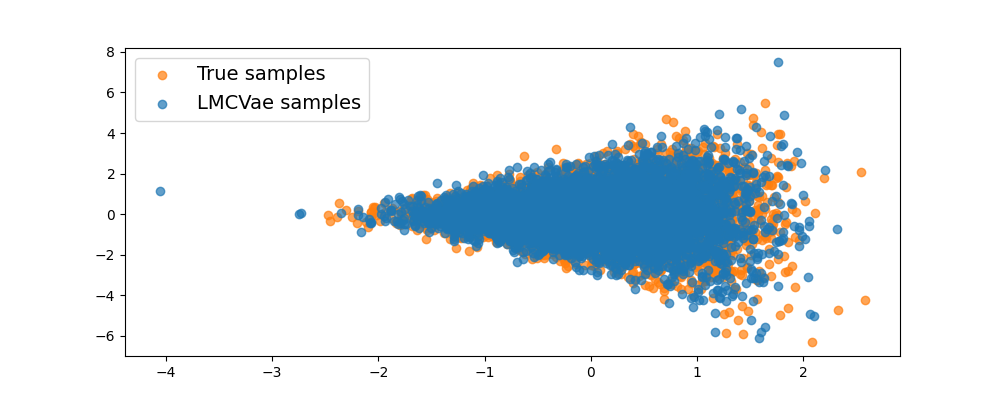

In [272]:
fig, axs = plt.subplots(1,1,figsize=(10,4))
axs.scatter(true_posterior_samples[:,0],true_posterior_samples[:,1],c='#ff7f0e', alpha = 0.7, label = "True samples")
axs.scatter(lmcvae_posterior_sample[:, 0] ,lmcvae_posterior_sample[:, 1],c='#1f77b4', alpha = 0.7, label = "LMCVae samples")


ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$')
plt.legend(fontsize=14)

plt.show()